In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import glob
import csv
import pandas as pd
from dateutil import tz
import datetime as dt
import seaborn as sns

from salishsea_tools import tidetools, places, geo_tools, viz_tools
import matplotlib.dates as md

from dateutil.relativedelta import relativedelta



%matplotlib inline

<b> Constants <b>

In [2]:


sns.set_palette('gray')
sns.set_style('ticks')
sns.set_color_codes

start = dt.datetime(2016, 7, 1, 0, 0)
end = dt.datetime(2016, 7, 29)



Iona = (-123.30807, 49.19026) #value from first point in traj.txt (Ariane output)

S15 = (-123.3114, 49.130412)
S16 = (-123.317415, 49.1214)
xl=(-126.2,-122.2)
yl=(47.1,51)

RAWDIR = "/ocean/gsgarbi/ariane_raw/2016+jan2017/"
    
OUTPUTDIR = "/ocean/gsgarbi/selected_days/"

H = 24

pph = 3

ppd = H * pph #(also number of outputs per trajectory per day since we have 3 outputs per hour)




Nancy's adapted functions

In [3]:
def list_wind_files(
    to, tf,
    wind_dir='/results/forcing/atmospheric/GEM2.5/operational/'
):
    """List operational wind files in date range [to, tf]

    :arg to: beginning of date range
    :type to: datetime object

    :arg tf: end of date range
    :type tf: datetime object

    :arg wind_dir: directory were wind files are stored
    :type wind_dir: str

    :returns: filesOP, a list of files in date range
    """

    
    
        
    sstr = to.strftime('ops_y%Ym%md%d.nc')
    estr = tf.strftime('ops_y%Ym%md%d.nc')
    files = glob.glob(os.path.join(wind_dir, 'ops_*.nc'))

    filesOP = []

    for filename in files:

        if os.path.basename(filename) >= sstr:
            if os.path.basename(filename) <= estr:
                filesOP.append(filename)

        filesOP.sort(key=os.path.basename)
     
#     for filename in filesOP:
#         if filename in sty_f:
#             filesSTY.append(filename)
#         else:
#             filesCTR.append (filename)
        

        
    
    filesOP.sort(key=os.path.basename)
    return filesOP


        
        

def compile_winds_study(j, i, files, study):
    """
    Compile a time series of operational atmospheric products stored in files
    at grid point j, i. First 24 hours of each file are used

    :arg j: the y-index of the grid point
    :type j: non-negative integer

    :arg i: the x-index of the grid point
    :type i: non-negative interger

    :arg files: list of atmospheric operational files
    :type files: list

    :returns: wind, direc, t, pr, tem, sol, the, qr, pre, all arrays
    wind speed, diretion, time, pressure, temperature, solar radiation,
    humidity, precipitation.

    """
    wind = []
    direc = []
    t = []
    pr = []
    sol = []
    the = []
    pre = []
    tem = []
    qr = []
    
    hours_dict = separate(study)
    
    
    
    for f in files:
        G = nc.Dataset(f)
        d = int(f [-5:-3])
        m = int(f [-8:-6])
        y = int(f [-13: -9])
        
        date = dt.date(y, m, d)
        
        if date in hours_dict.keys():
        
            hours = hours_dict[date]
        
        else:
            break
            
        
        u = []
        v = []
        for h in hours:
            u.append(G.variables['u_wind'][h, j, i])
            v.append(G.variables['v_wind'][h, j, i])
        
        u = np.array(u)
        v = np.array(v)
        
        speed = np.sqrt(u**2 + v**2)
        wind.append(speed)


        d = np.arctan2(v, u)
        d = np.rad2deg(d + (d < 0)*2*np.pi)
        direc.append(d)


#     wind = np.array(wind).reshape(numdays*24,)
#     direc = np.array(direc, 'double').reshape(numdays*24,)
#     t = np.array(t).reshape(numdays*24,)
#     pr = np.array(pr).reshape(numdays*24,)
#     tem = np.array(tem).reshape(numdays*24,)
#     sol = np.array(sol).reshape(numdays*24,)
#     the = np.array(the).reshape(numdays*24,)
#     qr = np.array(qr).reshape(numdays*24,)
#     pre = np.array(pre).reshape(numdays*24,)

    return wind

def find_model_point(lon, lat, X, Y, tol_lon=0.016, tol_lat=0.011):
    """Finds a model grid point close to a specified latitude and longitude.
    Should be used for non-NEMO grids like the atmospheric forcing grid.

    :arg lon: The longitude we are trying to match.
    :type lon: float

    :arg lat: The latitude we are trying to match.
    :type lat: float

    :arg X: The model longitude grid.
    :type X: numpy array

    :arg Y: The model latitude grid.
    :type Y: numpy array

    :arg tol_lon: tolerance on grid spacing for longitude
    :type tol_lon: float

    :arg tol_lat: tolerance on grid spacing for latitude
    :type tol_lat: float

    :returns: j-index and i-index of the closest model grid point.
    """

    # Search for a grid point with longitude or latitude within
    # tolerance of measured location
    j, i = np.where(
        np.logical_and(
            (np.logical_and(X > lon - tol_lon, X < lon + tol_lon)),
            (np.logical_and(Y > lat - tol_lat, Y < lat + tol_lat))))

    if j.size > 1 or i.size > 1:
        raise ValueError(
            'Multiple model points found. tol_lon/tol_lat too big.'
        )
    elif not j or not i:
        raise ValueError(
            'No model point found. tol_lon/tol_lat too small or '
            'lon/lat outside of domain.'
        )
    return j, i



def dateParserMeasured2(s):
    """
    converts string in %d-%b-%Y %H:%M:%S format Pacific time to a
    datetime object UTC time.
    """
    PST = tz.tzoffset("PST", -28800)
    # convert the string to a datetime object
    unaware = datetime.datetime.strptime(s, "%d-%b-%Y %H:%M:%S ")
    # add in the local time zone (Canada/Pacific)
    aware = unaware.replace(tzinfo=PST)
    # convert to UTC
    return aware.astimezone(tz.tzutc())




Get points and separate them according to chosen criteria.

In [4]:
def find_direct (RAWDIR, date, traj_len):
    'traj len needs to be equal to or less than 30 (days)'
    start = date
    end = date + dt.timedelta(days = traj_len) 
    y = str(start.year)
    m = str(start.month)
    n = str(end.month)
    w = str(end.year)
    


    if len (m) == 1:
        m = "0"+str(m)
        
    if len (n) == 1:
        n = "0"+str(n)
    
    direct = [ i for i in os.listdir(RAWDIR) if y+m == i[:6] or w+n == i[:6] ]
    
    direct = sorted(direct)
    
    print ("got directory(ies)")
    
    return direct

In [5]:
def get_points(direct, init_date, traj_len, phase = 0):
    '''
    get 72 trajs (3 per hour) starting on date.day with fixed traj len
    '''
    
    date0 = dt.datetime( init_date.year, init_date.month, 1, 0, 0)
    
    phase = phase * 3
    pts = []

    d = init_date.day
    #select the particles
    parts = range (1 + ppd*(d - 1) + phase, 1 + ppd*(d - 1) + phase + 72)

    part = parts[0]
    

    for directory in direct:


        with open(RAWDIR + directory + "/traj.txt") as file:
            
            

            count = 0
            traj = []
            
            date0 += relativedelta( months = direct.index(directory) )

            
            
            for i, line in enumerate(file):

                line = line.strip('\n').split()
                line = [float(k) for k in line]


                if line[0] == part:
                    

                    
                    mins0 = 60*int( (part-1)/3 )
                    
                    time = date0 + dt.timedelta( minutes = mins0) + dt.timedelta( minutes = count * 20)
                    
                    
                    traj.append(line + [time])
                    

                    count +=1
                if count == traj_len * ppd:

                    pts.append(traj)
                    traj = [] #reset traj
                    count = 0 #reset counter
                    part += 1 #go to the next particle

                if part == parts[-1]+1:
                    break
            else:
                    print ("month transition -> open next file")
                    


                    parts = range (1, parts[-1] - part)
                    part = parts[0]

    return pts

Trajectory analysis

In [6]:
def dist(p, q = S15):
    d = geo_tools.haversine (p[1],p[2], q[0], q[1])
    return d

In [7]:
def traj_analysis (traj, time = 24, distance = 1.2):

    age = 0
    
    date = [ traj[0][-1] + dt.timedelta(hours = h) for h in range (24) ] 
    
    for pt in traj:
        

        if (dist(pt, S15) < distance or dist(pt, S16) < distance) and traj.index(pt)/3 < time:

            
            age = traj.index(pt)/3
            break
    return (date, age)

In [8]:
def separate (study):
    dd = {}
    dates = [k.date() for k in study]
    for date in set(dates):
        dd[date] = []
    
    for date in study:
        dd[date.date()].append(int(date.hour))
        

        
    return dd

Analysis

In [9]:
pts = []

traj_len = 1 #24 hours

date = start


while date != end:
    
    direct = find_direct(RAWDIR, date, traj_len)
    
    pts.append(get_points(direct, date, traj_len, phase = 0))
    
    date = date + dt.timedelta (days = 1)

got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)
got directory(ies)


In [10]:
full_period = [k for sublist in pts for k in sublist]

In [11]:
results = []

for traj in full_period:
    results.append(traj_analysis(traj))

results = np.array(results)

print (results[:,1])
print (results[:,0][0])
print (len(results[:,0][0]))#works!

[0 15.666666666666666 16.666666666666668 ..., 0 0 0]
[datetime.datetime(2016, 7, 1, 0, 0), datetime.datetime(2016, 7, 1, 1, 0), datetime.datetime(2016, 7, 1, 2, 0), datetime.datetime(2016, 7, 1, 3, 0), datetime.datetime(2016, 7, 1, 4, 0), datetime.datetime(2016, 7, 1, 5, 0), datetime.datetime(2016, 7, 1, 6, 0), datetime.datetime(2016, 7, 1, 7, 0), datetime.datetime(2016, 7, 1, 8, 0), datetime.datetime(2016, 7, 1, 9, 0), datetime.datetime(2016, 7, 1, 10, 0), datetime.datetime(2016, 7, 1, 11, 0), datetime.datetime(2016, 7, 1, 12, 0), datetime.datetime(2016, 7, 1, 13, 0), datetime.datetime(2016, 7, 1, 14, 0), datetime.datetime(2016, 7, 1, 15, 0), datetime.datetime(2016, 7, 1, 16, 0), datetime.datetime(2016, 7, 1, 17, 0), datetime.datetime(2016, 7, 1, 18, 0), datetime.datetime(2016, 7, 1, 19, 0), datetime.datetime(2016, 7, 1, 20, 0), datetime.datetime(2016, 7, 1, 21, 0), datetime.datetime(2016, 7, 1, 22, 0), datetime.datetime(2016, 7, 1, 23, 0)]
24


In [12]:
control = []
study = []
for i in results:
    if i [1] == 0:
        control.append(i[0])
    else:
        study.append(i[0])

study_points = [k for sublist in study for k in sublist]
control_points = [k for sublist in control for k in sublist]

In [13]:
study_dictionary = separate (study_points)
print (study_dictionary)

study_dates = [key for key in study_dictionary.keys()]

print (study_dates)


print ('-------------------')


control_dictionary = separate (control_points)
print (control_dictionary)

control_dates = [key for key in control_dictionary.keys()]

print (control_dates)  

{datetime.date(2016, 7, 15): [19, 20, 21, 22, 23], datetime.date(2016, 7, 12): [22, 23, 23], datetime.date(2016, 7, 19): [0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], datetime.date(2016, 7, 2): [0, 0, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

In [14]:
#Iona = (-123.30898284912109, 49.187351226806641)
Iona = (-123.30807, 49.19026) #value from first point in traj.txt (Ariane output)


sdt = start
edt = end

OP = nc.Dataset('/ocean/gsgarbi/ops_y2014m11d18.nc')
OPlon =OP.variables['nav_lon'][:]-360
OPlat = OP.variables['nav_lat'][:]

lons, lats = OPlon, OPlat

lon, lat = [Iona[0], Iona[1]]
wind_files = list_wind_files(sdt, edt)


j,i=find_model_point(lon,lat,lons,lats)

windS = compile_winds_study(j,i,wind_files, study_points)
windC = compile_winds_study(j,i,wind_files, control_points)

In [15]:
study_group = [w[0][0] for sublist in windS for w in sublist]
control_group = [w[0][0] for sublist in windC for w in sublist]    

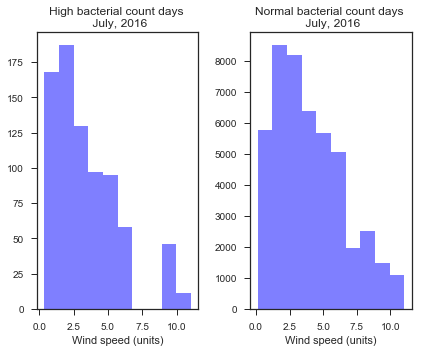

In [16]:
fig, axs = plt.subplots(1,2, figsize = (6,5))

axs[0].hist(study_group, alpha = 0.5, color = 'blue' )
axs[0].set_xlabel("Wind speed (units)")
axs[0].set_title("High bacterial count days \n July, 2016")
axs[1].hist(control_group, alpha = 0.5, color = 'blue' )
axs[1].set_xlabel("Wind speed (units)")
axs[1].set_title("Normal bacterial count days \n July, 2016")
plt.tight_layout()